In [5]:
# piRates are funny! R!

In [1]:
if (!require(pacman)){ #load packages
  install.packages("pacman")
  install.packages("RcmdrPlugin.KMggplot2")
}

pacman::p_load(char = c("tidyverse", "here","readstata13", 
                        "scales", "boot", "magrittr",  "mvtnorm", 
                        "zoo", "patchwork", "mgcv", "PropCIs", "showtext", "ggh4x"))
                        

Loading required package: pacman

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


readstata13 installed

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


boot installed

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


mvtnorm installed

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


PropCIs installed

also installing the dependencies ‘sysfonts’, ‘showtextdb’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


showtext installed

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


ggh4x installed



In [2]:
setwd(here::here())
here::here()

[1] "/workspaces/testes"

In [12]:
# written by Deus Thindwa & Samuel Clifford
# optimal age targeting for pneumoccocal vaccines against IPD in older adults
# exponential decay and growth models.
# 31/02/2022

# load the IPD cases and estimate uncertainty of observed IPD cases
scale = 100000
ipd <- readr::read_csv("https://raw.githubusercontent.com/deusthindwa/optimal.age.targeting.pneumo.vaccines/main/data/total_incidence.csv") %>%
# ipd <- readr::read_csv(here("data", "total_incidence.csv")) %>%
  mutate(agey = readr::parse_number(substr(agegroup, 1, 2)),
         obs = (cases/npop)*scale) %>%
  mutate(serogroup = ifelse(serogroup == "All serotypes", "All", serogroup)) %>%
  mutate(serogroup = factor(serogroup,
                            levels = c("All",
                                       "PPV23",
                                       "PCV20",
                                       "PCV15",
                                       "PCV13"))) %>% 
  dplyr::filter(!is.na(cases))

ipd %<>% nest(data = c(cases, npop)) %>%
  mutate(CI = map(.x = data, ~exactci(.x$cases, .x$npop, conf.level = 0.95)) %>%
           map('conf.int') %>%
           map(~data.frame(obs_lci = .x[1]*scale,
                           obs_uci = .x[2]*scale))) %>%
  unnest_wider(CI) %>%
  unnest_wider(data)

#---------- FIT USING NLS

# estimate the rest of parameters using a simple linear model
# log(y) = log(alpha0) + beta0*age
fit_model <- function(x){
  
  #set initial parameter values for the model
  model0 <- lm(log(incidence) ~ agey, data = x)
  start = list(alpha = exp(coef(model0)[1]), beta  = coef(model0)[2])
  
  #fit and NLS model
  nls(data = x,
  incidence ~ exp(alpha) * exp(beta*agey),
  nls.control(maxiter = 2000),
  start = start
  )
}

ipd_model <- ipd %>% nest(data = -c(serogroup, country)) %>%
  mutate(model = map(.x = data, ~fit_model(.x)))

#-------------------------------------------------------

# function to simulate model to generate uncertainty 
simulate_from_model <- function(x, newdata, nsim){
  V <- vcov(x)
  M <- coef(x)
  
  dat <- data.frame(rmvnorm(n = nsim, mean = M, sigma = V)) %>%
    mutate(sim = 1:n()) %>%
    crossing(newdata) %>%
    mutate(fit = predict(x, .)) %>%
    dplyr::select(fit, sim, one_of(names(newdata)))
  
  return(dat)
}

#-------------------------------------------------------

# run the simulations
nsims <- 1e3 # number of simulations to use for all uncertainty analysis
ipd_x <- data.frame(agey = seq(55, 90, by = 1))
# ipd_mc <- ipd_model %>% map(~simulate_from_model(.x, newdata = ipd_x, nsim = nsims))

ipd_mc <- mutate(ipd_model, mc = map(.x = model, ~simulate_from_model(.x, ipd_x, nsims)))

#-------------------------------------------------------

# function to wrap up 95% uncertainty levels
summarise_from_model <- function(x, probs = c(0.025, 0.5, 0.975)){
  nest(x, data = -agey) %>%
    mutate(Q = map(data, ~quantile(.x$fit, probs = probs))) %>%
    unnest_wider(Q) %>%
    dplyr::select(-data) %>%
    return
}

# summarise uncertainty

ipd_curves <- 
  mutate(ipd_mc, curves = map(.x = mc, summarise_from_model)) %>%
  select(-data, -model, -mc) %>%
  unnest(curves)

#-------------------------------------------------------

# generate relation table for ggplotting
# can't have less than 0
ipd_curves %<>% 
  mutate_at(.vars = vars(`2.5%`, `50%`, `97.5%`),
            .funs = ~pmax(0, .))

# plot fitted IPD incidence along with observed IPD cases with uncertainty
A <- 
  ggplot(data = ipd_curves) +
  geom_line(aes(x = agey, y = `50%`), size = 1) +
  geom_ribbon(aes(x = agey, y = `50%`,
                  ymin = `2.5%`, ymax = `97.5%`),
              alpha = 0.2, color = NA) +
  geom_point(data = ipd, aes(x = agey, y = obs), size = 2) +
  geom_linerange(data = ipd,
                 aes(x = agey, 
                     ymin = obs_lci, 
                     ymax = obs_uci)) +
  facet_grid(country  ~ serogroup, scales = "free_y") +
  scale_y_continuous(limits = c(0, NA), labels = ~sprintf("%g", .)) +
  labs(x = "Age (years)", 
       y = "IPD incidence per 100,000 population") +
  theme_bw(base_size = 14, base_family = "Lato") +
  theme(axis.text        = element_text(face = "bold"),
        strip.background = element_rect(fill = "white"),
        panel.border     = element_rect(colour = "black", fill=NA, size=1)) 

# # combined incidence plot
# ggsave(here("output", "Fig2_ipd_incidence.png"),
#        plot = A,
#        width = 10, height = 8, unit="in", dpi = 300)


Rows: 140 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): agegroup, serogroup, country
dbl (4): survyr, cases, npop, incidence

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


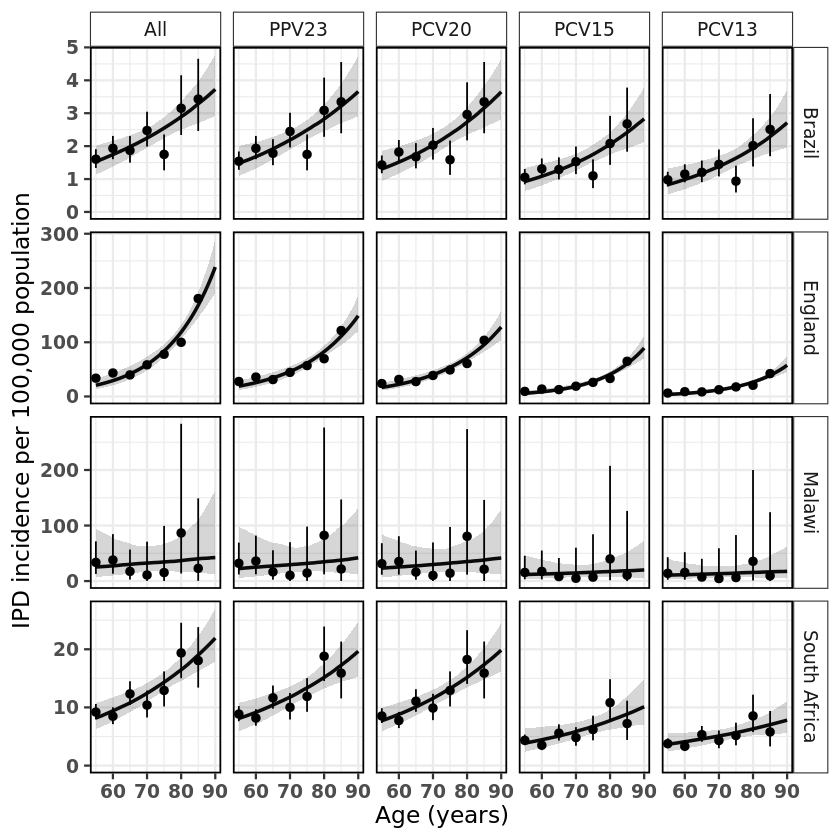

In [7]:
A
